In [1]:
from ase.build import make_supercell
from ase.io import read, write

import catkit
from catkit.gen.adsorption import get_adsorption_sites

from mcmc import mcmc_run
import os
import numpy as np

import sys
sys.path.append("/home/dux/")

os.environ["PROJECT_DIR"] = os.getcwd()

In [2]:
# SrTiO3 from HTVS db
import sys
import os
import django
import numpy as np
# from tqdm import tqdm
# import pandas as pd
# import pickle as pkl
sys.path.append('/home/dux/htvs/')
sys.path.append('/home/dux/htvs/djangochem/')

#from imports import *
#from django_imports import *
# from pymatgen.core.periodic_table import Element
# from chemconfigs.vasp.defaults import Magmom
# from ase.visualize import view

# setup the django settings file.  Change this to use the settings file that connects you to your desired database
os.environ["DJANGO_SETTINGS_MODULE"] = "djangochem.settings.orgel"
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"  # CAUTION!!! LINE NECESSARY WHEN INTERACTING WITH DATABASE IN JUPYTER NOTEBOOK. DO NOT USE THIS LINE IF YOU ARE PLANNING ON SAVING/REMOVING THINGS FROM THE DATABASE!!!!!

# this must be run to setup access to the django settings and make database access work etc.
django.setup()
# from jobs.models import Job, JobConfig
# from django.contrib.contenttypes.models import ContentType
# from ase.io import write

from pgmols.models import Surface
# from analysis.structure.perovskite import PerovskiteAnalyzer
# from pymatgen.core.periodic_table import Element

unit_slab = Surface.objects.get(id=217485271).as_ase_gratoms()
unit_slab.write('SrTiO3_001_pristine_slab.cif')

# get supercell
# multiplier = np.diag([4, 4, 1])
# slab = make_supercell(unit_slab, multiplier)
slab = unit_slab*(4,4,1)
slab.write('SrTiO3_001_4x4_pristine_slab.cif')

In [3]:
# manually get adsorption coords
coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)

# get absolute adsorption coords
element = 'O'
ads = catkit.gratoms.Gratoms(element)

# ads_coords = get_adsorption_coords(slab, ads, connectivity)

/home/dux/miniconda3/envs/htvs/lib/python3.7/site-packages/catkit/gen/adsorption.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/htvs/lib/python3.7/site-packages/catkit/gen/adsorption.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


In [4]:
# single multiplication for upsize
mul_superslab = unit_slab*(4,4,1)
from collections import Counter
Counter(mul_superslab.get_atomic_numbers())

Counter({8: 144, 38: 48, 22: 48})

In [6]:
mul_superslab.get_surface_atoms()

array([  7,   8,  14,  22,  23,  29,  37,  38,  44,  52,  53,  59,  67,
        68,  74,  82,  83,  89,  97,  98, 104, 112, 113, 119, 127, 128,
       134, 142, 143, 149, 157, 158, 164, 172, 173, 179, 187, 188, 194,
       202, 203, 209, 217, 218, 224, 232, 233, 239])

In [5]:
a_nums = mul_superslab.get_atomic_numbers()

In [6]:
# get surface atoms
surf_atoms = mul_superslab.get_surface_atoms()
a_nums[surf_atoms]

array([ 8,  8, 22,  8,  8, 22,  8,  8, 22,  8,  8, 22,  8,  8, 22,  8,  8,
       22,  8,  8, 22,  8,  8, 22,  8,  8, 22,  8,  8, 22,  8,  8, 22,  8,
        8, 22,  8,  8, 22,  8,  8, 22,  8,  8, 22,  8,  8, 22])

In [7]:
len(connectivity)
# original number of adsorption sites

256

In [8]:
# Get adsorption sites
coords.shape
ads_slab = read("SrTiO3_001_4x4_O_all_adsorbed_slab.cif")
Counter(ads_slab.get_atomic_numbers())
# All 240 oxygens are adsorbed

Counter({8: 384, 38: 48, 22: 48})

In [9]:
np.unique(ads_slab.get_positions(wrap=True), axis=1).shape

# set positions to wrapped
# all_ads_slab = read("SrTiO3_001_O_all_adsorbed_slab.cif")
# w_ads_slab = all_ads_slab.copy()
# w_ads_slab.set_positions(all_ads_slab.get_positions(wrap=True))
# w_ads_slab.write('SrTiO3_001_O_all_adsorbed_slab_wrapped.cif')

(480, 3)

Use smaller unit cell to figure out if sites are distinct

In [10]:
# Try a smaller unit cell to figure things out
from collections import Counter
Counter(unit_slab.get_atomic_numbers())

Counter({8: 9, 38: 3, 22: 3})

In [11]:
coords, connectivity, sym_idx = get_adsorption_sites(unit_slab, symmetry_reduced=False)
len(coords)

16

Use manually edited fully removed site (ase gui) to get updates

In [12]:
filtered_ads_slab = read("SrTiO3_001_4x4_O_filtered_adsorbed_slab.cif")
print(f"{len(filtered_ads_slab)}")
print(f"{len(mul_superslab)}")

376
240


In [13]:
ads_positions = filtered_ads_slab.get_positions()[len(mul_superslab):]
len(ads_positions)
# see that the # ads positions dropped

136

In [14]:
# slab = unit_slab*(4,4,1)
slab = mul_superslab
surface_name = "SrTiO3_001_4x4_filtered"

print("slab type", type(slab))
# num_runs = 500
# no calc, testing to just get some states
# history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=1, slab=slab, calc=None, testing=True, surface_name=surface_name, element=element, ads_coords=ads_positions)

slab type <class 'catkit.gratoms.Gratoms'>


Perform canonical updates instead

4x4 superslab

In [33]:
# do from 144 to 192 oxygen atoms
# so add a pristine slab
start_atoms = 144
end_atoms = 192
step = 2
scaling = (4,4,1)
num_runs = 100

for i in range(start_atoms+step, end_atoms, step):
    print(f"going for {i} atoms")
    num_ads_atoms =  i - start_atoms # for canonical runs
    alpha = 1
    slab = unit_slab*scaling
    surface_name = f"SrTiO3_001_4x4_filtered"

    filtered_ads_slab = read("SrTiO3_001_4x4_O_filtered_adsorbed_slab.cif")
    print(f"{len(filtered_ads_slab)}")
    print(f"{len(slab)}")
    
    ads_positions = filtered_ads_slab.get_positions()[len(slab):]

    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=None, testing=True, surface_name=surface_name, element=element, canonical=True, ads_coords=ads_positions, num_ads_atoms=num_ads_atoms)

going for 146 atoms
368
240


/home/dux/miniconda3/envs/htvs/lib/python3.7/site-packages/catkit/gen/adsorption.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/htvs/lib/python3.7/site-packages/catkit/gen/adsorption.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


going for 148 atoms
368
240
going for 150 atoms
368
240
going for 152 atoms
368
240
going for 154 atoms
368
240
going for 156 atoms
368
240
going for 158 atoms
368
240
going for 160 atoms
368
240
going for 162 atoms
368
240
going for 164 atoms
368
240
going for 166 atoms
368
240
going for 168 atoms
368
240
going for 170 atoms
368
240
going for 172 atoms
368
240
going for 174 atoms
368
240
going for 176 atoms
368
240
going for 178 atoms
368
240
going for 180 atoms
368
240
going for 182 atoms
368
240
going for 184 atoms
368
240
going for 186 atoms
368
240
going for 188 atoms
368
240
going for 190 atoms
368
240


3x3 superslab

In [35]:
# get the 3x3 adsorption sites
superslab_3x3 = unit_slab*(3,3,1)
num_runs = 1
surface_name = f"SrTiO3_001_3x3_manipulation"
# mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=superslab_3x3, calc=None, testing=True, surface_name=surface_name, element=element)

In [36]:
superslab_3x3.write('SrTiO3_001_3x3_pristine_slab.cif')

In [14]:
# do from 81 to 108 oxygen atoms
# so add a pristine slab
start_atoms = 81
end_atoms = 108
step = 1
scaling = (3,3,1)
num_runs = 100

for i in range(start_atoms+step, end_atoms, step):
    print(f"going for {i} atoms")
    num_ads_atoms =  i - start_atoms # for canonical runs
    alpha = 1
    slab = unit_slab*scaling
    surface_name = f"SrTiO3_001_3x3_filtered"

    filtered_ads_slab = read("SrTiO3_001_3x3_O_filtered_adsorbed_slab.cif")
    print(f"{len(filtered_ads_slab)}")
    print(f"{len(slab)}")
    
    ads_positions = filtered_ads_slab.get_positions()[len(slab):]

    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=None, testing=True, surface_name=surface_name, element=element, canonical=True, ads_coords=ads_positions, num_ads_atoms=num_ads_atoms)

going for 82 atoms
207
135
going for 83 atoms
207
135
going for 84 atoms
207
135
going for 85 atoms
207
135
going for 86 atoms
207
135
going for 87 atoms
207
135
going for 88 atoms
207
135
going for 89 atoms
207
135
going for 90 atoms
207
135
going for 91 atoms
207
135
going for 92 atoms
207
135
going for 93 atoms
207
135
going for 94 atoms
207
135
going for 95 atoms
207
135
going for 96 atoms
207
135
going for 97 atoms
207
135
going for 98 atoms
207
135
going for 99 atoms
207
135
going for 100 atoms
207
135
going for 101 atoms
207
135
going for 102 atoms
207
135
going for 103 atoms
207
135
going for 104 atoms
207
135
going for 105 atoms
207
135
going for 106 atoms
207
135
going for 107 atoms
207
135


2x2 superslab

In [37]:
# get the 2x2 adsorption sites
superslab_2x2 = unit_slab*(2,2,1)
num_runs = 1
surface_name = f"SrTiO3_001_2x2_manipulation"
# mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=superslab_2x2, calc=None, testing=True, surface_name=surface_name, element=element)

In [38]:
superslab_2x2.write('SrTiO3_001_2x2_pristine_slab.cif')

In [12]:
# do from 36 to 48 oxygen atoms
# so add a pristine slab
start_atoms = 36
end_atoms = 48
step = 1
scaling = (2,2,1)
num_runs = 100

for i in range(start_atoms+step, end_atoms, step):
    print(f"going for {i} atoms")
    num_ads_atoms =  i - start_atoms # for canonical runs
    alpha = 1
    slab = unit_slab*scaling
    surface_name = f"SrTiO3_001_2x2_filtered"

    filtered_ads_slab = read("SrTiO3_001_2x2_O_filtered_adsorbed_slab.cif")
    print(f"{len(filtered_ads_slab)}")
    print(f"{len(slab)}")
    
    ads_positions = filtered_ads_slab.get_positions()[len(slab):]

    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=None, testing=True, surface_name=surface_name, element=element, canonical=True, ads_coords=ads_positions, num_ads_atoms=num_ads_atoms)

going for 37 atoms
92
60
going for 38 atoms
92
60
going for 39 atoms
92
60
going for 40 atoms
92
60
going for 41 atoms
92
60
going for 42 atoms
92
60
going for 43 atoms
92
60
going for 44 atoms
92
60
going for 45 atoms
92
60
going for 46 atoms
92
60
going for 47 atoms
92
60


For 4x4 collate atoms (no need to filter)

In [42]:
import glob
# collate items
# for 4x4
structure_folders = glob.glob("SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms??_alpha1*")
structure_folders.sort()
print(structure_folders)
assert len(structure_folders) == 23

['SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms02_alpha1_20220405-1608', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms04_alpha1_20220405-1608', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms06_alpha1_20220405-1609', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms08_alpha1_20220405-1609', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms10_alpha1_20220405-1610', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms12_alpha1_20220405-1610', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms14_alpha1_20220405-1610', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms16_alpha1_20220405-1611', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms18_alpha1_20220405-1611', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms20_alpha1_20220405-1612', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms22_alpha1_20220405-1612', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms24_alpha1_20220405-1612', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms26_alpha1_20220405-1613', 'SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms28_

In [43]:
slabs = ["final_slab_run_050.cif"]
ads_slabs = []
for f in structure_folders:
    for slab in slabs:
        ads_slabs.append(os.path.join(f, slab))

import shutil
collate_path = "SrTiO3_001_4x4_filtered/collated"
if not os.path.exists(collate_path):
    os.makedirs(collate_path)
for i, slab in enumerate(ads_slabs):
    move_path = os.path.join(collate_path, f"slab_{i+1:03}.cif")
    print(f"move from {slab} to {move_path}")
    shutil.copy2(slab, move_path)

move from SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms02_alpha1_20220405-1608/final_slab_run_050.cif to SrTiO3_001_4x4_filtered/collated/slab_001.cif
move from SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms04_alpha1_20220405-1608/final_slab_run_050.cif to SrTiO3_001_4x4_filtered/collated/slab_002.cif
move from SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms06_alpha1_20220405-1609/final_slab_run_050.cif to SrTiO3_001_4x4_filtered/collated/slab_003.cif
move from SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms08_alpha1_20220405-1609/final_slab_run_050.cif to SrTiO3_001_4x4_filtered/collated/slab_004.cif
move from SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms10_alpha1_20220405-1610/final_slab_run_050.cif to SrTiO3_001_4x4_filtered/collated/slab_005.cif
move from SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms12_alpha1_20220405-1610/final_slab_run_050.cif to SrTiO3_001_4x4_filtered/collated/slab_006.cif
move from SrTiO3_001_4x4_filtered/runs100_temp1_adsatoms14_alpha1_20220405-1610/final_sl

For 3x3 collate atoms

In [26]:
import glob
# collate items
# for 3x3
structure_folders = glob.glob("SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms??_alpha1*")
structure_folders.sort()
print(structure_folders)
assert len(structure_folders) == 26


['SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms01_alpha1_20220405-1456', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms02_alpha1_20220405-1456', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms03_alpha1_20220405-1457', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms04_alpha1_20220405-1457', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms05_alpha1_20220405-1457', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms06_alpha1_20220405-1457', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms07_alpha1_20220405-1457', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms08_alpha1_20220405-1457', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms09_alpha1_20220405-1457', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms10_alpha1_20220405-1458', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms11_alpha1_20220405-1458', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms12_alpha1_20220405-1458', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms13_alpha1_20220405-1458', 'SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms14_

In [32]:
slabs = ["final_slab_run_050.cif", "final_slab_run_090.cif"]
ads_slabs = []
for f in structure_folders:
    for slab in slabs:
        ads_slabs.append(os.path.join(f, slab))

import shutil
collate_path = "SrTiO3_001_3x3_filtered/collated"
if not os.path.exists(collate_path):
    os.makedirs(collate_path)
for i, slab in enumerate(ads_slabs):
    move_path = os.path.join(collate_path, f"slab_{i+1:03}.cif")
    print(f"move from {slab} to {move_path}")
    shutil.copy2(slab, move_path)

move from SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms01_alpha1_20220405-1456/final_slab_run_050.cif to SrTiO3_001_3x3_filtered/collated/slab_001.cif
move from SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms01_alpha1_20220405-1456/final_slab_run_090.cif to SrTiO3_001_3x3_filtered/collated/slab_002.cif
move from SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms02_alpha1_20220405-1456/final_slab_run_050.cif to SrTiO3_001_3x3_filtered/collated/slab_003.cif
move from SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms02_alpha1_20220405-1456/final_slab_run_090.cif to SrTiO3_001_3x3_filtered/collated/slab_004.cif
move from SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms03_alpha1_20220405-1457/final_slab_run_050.cif to SrTiO3_001_3x3_filtered/collated/slab_005.cif
move from SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms03_alpha1_20220405-1457/final_slab_run_090.cif to SrTiO3_001_3x3_filtered/collated/slab_006.cif
move from SrTiO3_001_3x3_filtered/runs100_temp1_adsatoms04_alpha1_20220405-1457/final_sl

For 2x2 collate atoms

In [44]:
import glob
# collate items
# for 2x2
structure_folders = glob.glob("SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms??_alpha1*")
structure_folders.sort()
print(structure_folders)
assert len(structure_folders) == 11


['SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms01_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms02_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms03_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms04_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms05_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms06_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms07_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms08_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms09_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms10_alpha1_20220405-1442', 'SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms11_alpha1_20220405-1442']


In [45]:
slabs = ["final_slab_run_010.cif", "final_slab_run_030.cif", "final_slab_run_050.cif", "final_slab_run_070.cif", "final_slab_run_090.cif"]
ads_slabs = []
for f in structure_folders:
    for slab in slabs:
        ads_slabs.append(os.path.join(f, slab))

import shutil
collate_path = "SrTiO3_001_2x2_filtered/collated"
if not os.path.exists(collate_path):
    os.makedirs(collate_path)
for i, slab in enumerate(ads_slabs):
    move_path = os.path.join(collate_path, f"slab_{i+1:03}.cif")
    print(f"move from {slab} to {move_path}")
    shutil.copy2(slab, move_path)

move from SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms01_alpha1_20220405-1442/final_slab_run_010.cif to SrTiO3_001_2x2_filtered/collated/slab_001.cif
move from SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms01_alpha1_20220405-1442/final_slab_run_030.cif to SrTiO3_001_2x2_filtered/collated/slab_002.cif
move from SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms01_alpha1_20220405-1442/final_slab_run_050.cif to SrTiO3_001_2x2_filtered/collated/slab_003.cif
move from SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms01_alpha1_20220405-1442/final_slab_run_070.cif to SrTiO3_001_2x2_filtered/collated/slab_004.cif
move from SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms01_alpha1_20220405-1442/final_slab_run_090.cif to SrTiO3_001_2x2_filtered/collated/slab_005.cif
move from SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms02_alpha1_20220405-1442/final_slab_run_010.cif to SrTiO3_001_2x2_filtered/collated/slab_006.cif
move from SrTiO3_001_2x2_filtered/runs100_temp1_adsatoms02_alpha1_20220405-1442/final_sl

Check slabs to make sure they are distinct

In [59]:
from ase.utils.structure_comparator import SymmetryEquivalenceCheck
comp = SymmetryEquivalenceCheck()
import pickle
import glob

In [60]:
# load 2x2 structures
slab_paths = glob.glob("SrTiO3_001_2x2_filtered/collated/*")
slab_paths.sort()
slabs = [read(x) for x in slab_paths]
# set tags; 1 for surface atoms, 2 for adsorbates, 0 for others
superslab = unit_slab*(2,2,1)
surface_atoms = superslab.get_surface_atoms()
atoms_arr = np.arange(1, len(superslab)+1)
base_tags = np.int8(np.isin(atoms_arr, surface_atoms)).tolist()

for slab in slabs:
    num_ads_atoms = len(slab) - len(superslab)
    tags = list(base_tags)
    tags.extend([2]*num_ads_atoms)
    slab.set_tags(tags)

equivalent_slab = []
for i in range(len(slabs)):
    for j in range(i+1, len(slabs)):
        if comp.compare(slabs[i], slabs[j]):
            equivalent_slab.append((i,j))

equivalent_slab
# so exclude 1 and 2

[(1, 3), (2, 5)]

In [64]:
chosen_slabs = slabs.copy()
del chosen_slabs[1]
del chosen_slabs[1]
assert len(chosen_slabs) == len(slabs) - 2

print(f"slab length {len(chosen_slabs)}")
with open("SrTiO3_001_2x2_O_ads_slabs.pkl", "wb") as f:
    pickle.dump(chosen_slabs, f)

slab length 54


In [65]:
# load 3x3 structures
slab_paths = glob.glob("SrTiO3_001_3x3_filtered/collated/*")
slab_paths.sort()
slabs = [read(x) for x in slab_paths]
# set tags; 1 for surface atoms, 2 for adsorbates, 0 for others
superslab = unit_slab*(3,3,1)
surface_atoms = superslab.get_surface_atoms()
atoms_arr = np.arange(1, len(superslab)+1)
base_tags = np.int8(np.isin(atoms_arr, surface_atoms)).tolist()

for slab in slabs:
    num_ads_atoms = len(slab) - len(superslab)
    tags = list(base_tags)
    tags.extend([2]*num_ads_atoms)
    slab.set_tags(tags)

equivalent_slab = []
for i in range(len(slabs)):
    for j in range(i+1, len(slabs)):
        if comp.compare(slabs[i], slabs[j]):
            equivalent_slab.append((i,j))

equivalent_slab
# so exclude 1

[(1, 2)]

In [66]:
chosen_slabs = slabs.copy()
del chosen_slabs[1]
assert len(chosen_slabs) == len(slabs) - 1

print(f"slab length {len(chosen_slabs)}")
with open("SrTiO3_001_3x3_O_ads_slabs.pkl", "wb") as f:
    pickle.dump(chosen_slabs, f)

slab length 52


In [67]:
# load 4x4 structures
slab_paths = glob.glob("SrTiO3_001_4x4_filtered/collated/*")
slab_paths.sort()
slabs = [read(x) for x in slab_paths]
# set tags; 1 for surface atoms, 2 for adsorbates, 0 for others
superslab = unit_slab*(4,4,1)
surface_atoms = superslab.get_surface_atoms()
atoms_arr = np.arange(1, len(superslab)+1)
base_tags = np.int8(np.isin(atoms_arr, surface_atoms)).tolist()

for slab in slabs:
    num_ads_atoms = len(slab) - len(superslab)
    tags = list(base_tags)
    tags.extend([2]*num_ads_atoms)
    slab.set_tags(tags)

print(f"slab length {len(slabs)}")
with open("SrTiO3_001_4x4_O_ads_slabs.pkl", "wb") as f:
    pickle.dump(slabs, f)

slab length 24


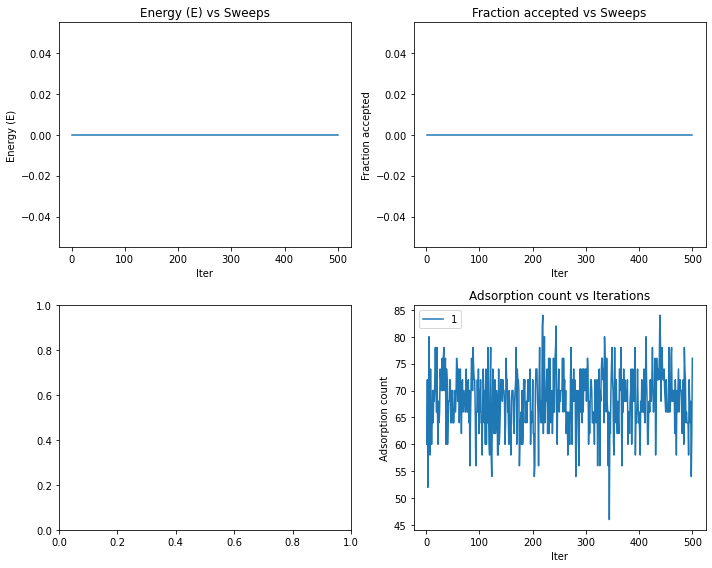

In [38]:
import matplotlib.pyplot as plt
runs = range(1, num_runs+1)

# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()